In [1]:
%matplotlib inline
import string
import cartopy.crs as ccrs
import pjr
import numpy as np
from timeit import default_timer as timer
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import cdms2
import cdutil
import re
import cdtime
import glob


pjr.py complete


test latex syntax $a = b^2$

In [2]:
# a useful function for interpolating model to new levels
def rescale (F, factor=None, myunits=None, offset=None):
    name = F.id
    if ((not offset is None) & (not factor is None)):
        print("rescale cannot set both offset and factor")
        # if you want to then exit the program
        import sys
        sys.exit(1)
    if not offset is None:
        F = F - offset;
    if not factor is None:
        F = F*Factor
    if not myunits is None:
        F.units = myunits 
    if F.id is "TREFHT":
        F = F - 273.15
        F.units = "C"
    if F.id is "TGCLDIWP":
        F = F*1.e3
        F.units = 'g/m2'
    if F.id is "TGCLDLWP":
        F = F*1.e3
        F.units = 'g/m2'
    if F.id is "BURDEN2":
        F = F*1.e6
        F.units = "mg/m2"
        
    F.id = name
    return F;

# a useful function for interpolating model to new levels
def getfld (fspec, vname, levs=None, time=None):
    """get zonal average field from model on pressure levels"""
    F =  fspec(vname,squeeze=1, time=time)            # extract fields, remove dimensions length one
    if vname is "TREFHT":
        F = F - 273.15
        F.units = "C"
    if vname is "TGCLDIWP":
        F = F*1.e3
        F.units = 'g/m2'
    if vname is "TGCLDLWP":
        F = F*1.e3
        F.units = 'g/m2'
        
    if not levs is None:
        print "interpolate to pressure levels", levs
        ps = fspec('PS',squeeze=1)
        hyam = fspec('hyam',squeeze=1)
        hybm = fspec('hybm',squeeze=1)

        start = timer()
        P = cdutil.reconstructPressureFromHybrid (ps,hyam,hybm,1.e5)
        P = P/100.; P.units = "hPa"
        stop1 = timer()
        print  "reconstruct P time = ", stop1-start
        FP1 = cdutil.logLinearInterpolation(F,P,levels=levs)
        stop2 = timer()
        print "interp time", stop2-stop1

        F = FP1

    F.id = vname
    return F;


def getdat (g0, vnameo, g1, g2, vname):
    """function to get model and obs datasets, move them to a common pressure coord grid
    returns:
        the observations (TP0xav)
        difference of model1 and obs (DT1xav)
        difference of model2 and obs (DT2xav)
    """
    T0 =  g0(vnameo,squeeze=1)            # get obs
    TM0 = g2(vname,squeeze=1) # get a model grid so we can do horizontal regrid obs
    T0 = T0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid

    T1 = getfld (g1, vname)


    T2 = getfld (g2, vname)


    DT2 = T2 - T0
    DT1 = T1 - T0

    return T0, DT1, DT2;


    
# a class that can hold model and observational names 
class vsets(object):
    def __init__(self, name=None, mname=None, oname=None, hash={}) :
         self.name = name
         self.mname = mname
         self.oname = oname

    

In [3]:
from matplotlib import gridspec
import matplotlib.path as mpath
def setup3 ():
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    sbnd = 60.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    fig = plt.figure(figsize=(4, 8)) 
    gs = gridspec.GridSpec(3, 2, width_ratios=[10, 1]) 

    ax0 = plt.subplot(gs[0],projection=ccrs.NorthPolarStereo())
    ax0.set_extent([-180, 180, sbnd, 90], ccrs.PlateCarree())
    ax0.set_boundary(circle, transform=ax0.transAxes)
#   ax0.set_global() # make axis consistent with projection limits
    cx0 = plt.subplot(gs[1])
    
    ax1 = plt.subplot(gs[2],projection=ccrs.NorthPolarStereo())
    ax1.set_global() # make axis consistent with projection limits
    ax1.set_extent([-180, 180, sbnd, 90], ccrs.PlateCarree())
    ax1.set_boundary(circle, transform=ax1.transAxes)
    cx1 = plt.subplot(gs[3])
    ax2 = plt.subplot(gs[4],projection=ccrs.NorthPolarStereo())
    ax2.set_global() # make axis consistent with projection limits
    ax2.set_extent([-180, 180, sbnd, 90], ccrs.PlateCarree())
    ax2.set_boundary(circle, transform=ax2.transAxes)
    cx2 = plt.subplot(gs[5])
    return fig,[ax0,ax1,ax2],[cx0,cx1,cx2];

def setup1 ():
    fig = plt.figure(figsize=(6, 3)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1]) 
    ax0 = plt.subplot(gs[0],projection=ccrs.Orthographic(0, 90))
    ax0.set_global() # make axis consistent with projection limits
    cx0 = plt.subplot(gs[1])
    return fig,ax0,cx0;

def defset (data, plotOpt, attribute):
    """return a sensible attribute
    if data is a numpy array, the default is an empty string
    if data is a smarter object like a cdms var it looks for an attribute
        if present that becomes the default
        else default is empty string
    if plotOpt dictionary contains a value, that is the returned quantity
    """
#    print "defset searching for ", attribute
    if hasattr(data,attribute):
        defval = getattr(data,attribute)
#        print attribute, "present, defval set to", defval
        #    variance.units = '(%s)^2'%var.units
    else:
#        print "no attribute defval set empty"
        defval = None
    val = plotOpt.get(attribute,defval)
#    print "defset returning", val
    return val;


def pltframe (data, lons=None, lats=None, fig=None, axo=None, cxo=None,plotOpt=None):
    """Create a robinson projection contour plot of one variable
    axo = the axes that we make the plot on 
    data = 2d numpy array (or data structure base on numpy) ordered (latitude, pressure
)
    lons = optional mesh  of longitude (same shape as data)
    lats = 1d numpy array of latitudes (")
    plotOpt is a optional dictionary with plotting options:
      'scale_factor': multiply values with this factor before plotting
      'units': a units label for the colorbar
      'clevs': use list of values as contour intervals
      'cmap': the color map to use
      'cabv': the above color
      'cbel': the below color
      'colorbar': location of colorbar ('bot','top','left','right','None')
      'rmClev': contour level to delete; frequently Zero, see findNiceContours
      'title': a title for the plot
    """
#    print "pltframe"
    if plotOpt is None: plotOpt = {}
    clevs = plotOpt.get("clevs") 
#    print "pltframe plotOpt clevs", clevs
    rmClev = plotOpt.get("rmClev")
#    print "pltframe rmClev", rmClev
    if clevs is None:
#        print "clevs undefined"
        clevs = pjr.findNiceContours(data,rmClev=rmClev)
    print "data range",data.min(), data.max()
#   print "pltframe final clevs", clevs
    cmap = plotOpt.get("cmap")
    if cmap is None:
        cmap = mpl.cm.get_cmap()
    norm = mpl.colors.BoundaryNorm(clevs,cmap.N)
    scale_factor = plotOpt.get('scale_factor', 1.0)
    pdata = data * scale_factor
    # add a title
    title = defset(data, plotOpt,"title")
    if not title is None: axo.set_title(title,loc='center')
    ltitle = defset(data, plotOpt,"ltitle")
    if not ltitle is None: axo.set_title(ltitle,loc='left')
    rtitle = defset(data, plotOpt,"rtitle")
    if not rtitle is None: axo.set_title(rtitle,loc='right')
    conout = axo.contourf(lons, lats, pdata, levels=clevs, 
        norm=norm, cmap=cmap, transform=ccrs.PlateCarree(),extend='both')
    noCbar = plotOpt.get("noCbar")
    if noCbar is None:
        cabv = plotOpt.get("cabv",'green') 
        conout.cmap.set_over(cabv)
        cbel = plotOpt.get('cbel','grey')
        conout.cmap.set_under(cbel)
        cbar = fig.colorbar(conout, cax=cxo,  orientation="vertical",ticks=clevs)
        labelFontSize = "small"
        units = defset(data, plotOpt,"units")
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(labelFontSize)
            #cbar.set_label(units)
        if not units is None: cbar.ax.set_title('('+units+')',pad=5)
    else:
        cxo.axis('off')
 
    axo.coastlines()
    axo.gridlines()
#    print"pltframe done"

def pltdat(T1, T2, DT):
    cmap = plt.cm.viridis
    lons = T1.getLongitude()
    lats = T1.getLatitude()
#    print TP0.info()
    dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
    clevs = pjr.findNiceContours(dtrng)
    
    pltframe(T2, lons, lats, ax3[0], cx3[0], 
             plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

    pltframe(T1, lons, lats, ax3[1], cx3[1], 
             plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})
    cmap = pjr.diverge_map()
    dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
#    print "T1.info", T1.info()
#    print "DT info", DT.info()
    print "DT.id", DT.id
    if DT.id == 'LWCF':
        dlevs = [-5.,4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
    if DT.id == 'SWCF':
        dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
    if DT.id == 'TS':
        dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
    if DT.id == 'TGCLDIWP':
        dlevs = [-5.,-2.,-1.,1.,2.,5.]
        
    dtitle = ltitD
    pltframe(DT, lons, lats, ax3[2], cx3[2], 
             plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})

def pltdat1(T1, T2, DT):
#   just do one frame
    cmap = plt.cm.viridis
    lons = T1.getLongitude()
    lats = T1.getLatitude()
#    print TP0.info()
    dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
    clevs = pjr.findNiceContours(dtrng)
    
#    pltframe(T2, lons, lats, ax3[0], cx3[0], 
#             plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

#    pltframe(T1, lons, lats, ax3[1], cx3[1], 
#             plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})
    cmap = pjr.diverge_map()
    dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
#    print "T1.info", T1.info()
#    print "DT info", DT.info()

    print "DT.id", DT.id
    if DT.id == 'LWCF':
        dlevs = [-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
    if DT.id == 'SWCF':
        dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
    if DT.id == 'TS':
        dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
    if DT.id == 'TGCLDIWP':
        dlevs = [-5.,-2.,-1.,1.,2.,5.]
    if DT.id == 'FSNT':
        dlevs = [-15.,-10.,-5.,-2.,-1.,1.,2.,5.,10.,15.]
        
    dtitle = ltitD
    pltframe(DT, lons, lats, fig, ax1, cx1, 
             plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})


In [4]:
# a cell in preparation to do the real model intercomparison
# a rigorous decomposition of fields over land, ocean and sea ice, 
# and assessment of implications of masking
# note that all these results depend upon 
# when during processing you apply the weighting and masking

# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list

#vlist.append(vsets('TGCLDLWP', 'TGCLDLWP','TGCLDLWP'))
#vlist.append(vsets('TGCLDIWP', 'TGCLDIWP','TGLDLIWP'))

#vlist.append(vsets("FSNT", "FSNT","FSNT"))
#vlist.append(vsets("FLNS", "FLNS","FLNS"))
vlist.append(vsets("TMQ", "TMQ","TMQ"))
#vlist.append(vsets("SST", "SST","SST"))
#vlist.append(vsets("FSNTC", "FSNTC","FSNTC"))
#vlist.append(vsets("FLNT", "FLNT","FLNT"))
#vlist.append(vsets("FLNTC", "FLNTC","FLNTC"))
#vlist.append(vsets('TREFHT', 'TREFHT','TREFHT'))
#vlist.append(vsets('LWCF', 'LWCF','LWCF'))
#vlist.append(vsets("Aer Opt Depth", "AEROD_v","AEROD_v"))
#vlist.append(vsets("Solar Insolation", "SOLIN", "SOLIN"))
#vlist.append(vsets("Surface Temperature", "TS", "tsrf"))
#vlist.append(vsets('SWCF', 'SWCF','SWCF'))
#vlist.append(vsets('CLDTOT', 'CLDTOT','CLDTOT'))
#vlist.append(vsets('CLDLOW', 'CLDLOW','CLDLOW'))
#vlist.append(vsets('CLDMED', 'CLDMED','CLDMED'))
#vlist.append(vsets('CLDHGH', 'CLDHGH','CLDHGH'))


def nameSort(e):
    return e.name

vlist.sort(key=nameSort)

#vlist.append(vsets("Precipitation", "PRECL","PRECL"))
#vlist.append(vsets("", "U", "ua"))
 
seaslist = ["ANN","JJA","DJF"]
seaslist = ["JAN"]

In [5]:
# identify fields to be evaluated


def setupfilenames (mon):
    import fnmatch
    import os
    # model2 dataset (the experiment)
    dir2 = "/dtemp/st49401/d3x345/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
#    dir2 = "/dtemp/st49401/zhan686/yotc/f02/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
    files = fnmatch.filter(os.listdir(dir2), "*cam.h1.2009-"+mon+"*00.nc")
#    print "files", files
    
    # the "reference" dataset
    dir1 = "/dtemp/st49401/d3x345/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
#    dir1 = "/dtemp/st49401/zhan686/yotc/f02/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
    f1 = "yotc_f02_pdil_sat_"+mon+".cam.h0.2009-"+mon+".nc"

    
#   print "all",files
#    files = files

#    for f2 in files:
#        #print "f2 is ", f2
#        print(f2)
    
    return dir1, f1, dir2, files



In [6]:

def processtime(vname, dir1, f1, dir2, files):
    
    print "processing time average"
# model1 dataset (the reference)

    title1 = "MONAVG"
    ltit1 = title1  
    rtit1 = ""
    jname1 = dir1+f1
    print "jname1 ", jname1    

    g1 = cdms2.open(jname1);
    print "reference dataset is jname1", jname1  

#    varlist2 = g2.listvariables();
#   varlist = [x for x in varlist if re.match(r'^.*CLD.*',x)]
#    print "g2 varlist", varlist2
#    dims2 = g2.listdimension();
#    print "g2 dims", dims2    
    

    T1 = getfld(g1,vname,time=slice(0,1)) # first time slice
    T1 = rescale(T1);
#    print "T1 shape", T1.shape

    print "processing timeslice from dir2 ", dir2
    for f2 in files:

        # model2 dataset (the experiment) 
        jname2 = dir2+f2
        g2 = cdms2.open(jname2);
        print "jname2", jname2
        varlist = g2.listvariables();
    #   varlist = [x for x in varlist if re.match(r'^.*CLD.*',x)]
    #    print "g2 varlist", varlist
        dims = g2.listdimension();
    #   print "j2 dims"
        dims = g2.listdimension();
        tindex = dims.index('time')
    #   print "tindex", tindex
        diminfo = g2[dims[tindex]].attributes
        #xx = g2[dims[tindex]].asComponentTime()
        #print "xx",xx
    #    print "diminfo", diminfo
        timeunits = diminfo['units']
        #print "timeunits", timeunits
        times = g2[dims[tindex]][:]
        #print "times", times
        starttime = g2[dims[tindex]][0]
        #print "starttime", starttime

    #if 1 == 1:
        thistime = times[0]
    #for thistime in times:
        #print "thistime", thistime

        #T2 = getfld(g2,vname,time=slice(0,1))
        T2 = getfld(g2,vname,time=thistime)
        T2 = rescale(T2)
        rt = cdtime.reltime(thistime, timeunits)
        #print "rt", rt
        ct = rt.tocomp()
        #help(ct)
        #print "ct", ct

        title2 = "{:.2f}".format(thistime)
        title2 = ct
        ltit2 = title2
        rtit2 = ""

    # if 1 == 1:
        sbnd = 60.
        T1 = T1.subRegion(latitude=(sbnd,90.))
        T2 = T2.subRegion(latitude=(sbnd,90.))


    #    T2 = getfld(g2,"QV")
    #    DELP = getfld(g2,'DELP')
    #    T2V = T2*DELP/9.806

    #    T2V = cdutil.averager(T2V,axis="t",weights='unweighted')
    #    T2V = cdutil.averager(T2V,axis="z",weights='equal', action='sum')
    #    print "range", T2V.min(), T2V.max()
    #    pltframe(T2V, lons, lats, ax3[0], cx3[0])    
    #    T2 = T2V    

        if plottype == "DIFF":
            DT = T2 - T1
        else:
            DT = T2/T1
            DT.units = "Ratio"

        DT.id = T1.id

        ctstring = "{:04d}_{:02d}_{:02d}h{:02d}".format(ct.year, ct.month, ct.day, ct.hour)
        if plottype == "DIFF":
            pltname = "workdir/"+vname+"_"+ctstring+"_D.pdf"
        else:
            pltname = "workdir/"+vname+"_"+ctstring+"_R.pdf"

        lons = T1.getLongitude()
        lats = T1.getLatitude()
    #   pltframe(T1, lons, lats, ax3[1], cx3[1])# , 
        #plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})

        print "figure being saved to ", pltname
        fig, ax3, cx3 = setup3()
    #    pltframe(DT, lons, lats, ax3[2], cx3[2]) #, 
        #  plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})    

        cmap = plt.cm.viridis

    #    print "plotting MERRA2"
    #    print TP0.info()
        dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
        clevs = pjr.findNiceContours(dtrng)
        if T1.id == "BURDEN2":
            clevs = np.array([0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0])*0.1

        pltframe(T2, lons, lats, fig, ax3[0], cx3[0], 
                 plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

    #    print "plotting E3SM"
        pltframe(T1, lons, lats, fig, ax3[1], cx3[1], 
                 plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})

        cmap = pjr.diverge_map()
    #   cmap = plt.cm.viridis


    #    print "T1.info", T1.info()
    #    print "DT info", DT.info()

    #    print "DT.id", DT.id
        if plottype == "DIFF":
            dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
            if DT.id == 'LWCF':
                dlevs = [-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
            if DT.id == 'SWCF':
                dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
            if DT.id == 'TS':
                dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
            if DT.id == 'TGCLDIWP':
                dlevs = [-5.,-2.,-1.,1.,2.,5.]
            if DT.id == 'FSNT':
                dlevs = [-15.,-10.,-5.,-2.,-1.,1.,2.,5.,10.,15.]
            if DT.id == 'BURDEN1':
                #    dlevs = np.array([0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.])*dfact
                dlevs = np.array([-0.2,-0.10,-0.05,-0.02, 0.02, 0.05,0.1,0.2])
            if DT.id == 'BURDEN2':
                #    dlevs = np.array([0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.])*dfact
                dlevs = np.array([-0.2,-0.10,-0.05,-0.02, 0.02, 0.05,0.1,0.2])

        else:
            # ratio plots
            dtrng = np.array([0.,DT.max()])
            print "dtrng", dtrng
            dtrng = dtrng*0.5
            dlevs = pjr.findNiceContours(dtrng,nlevs=12,rmClev=0, sym=True)
            print "dlevs1", dlevs
            dlevs = (dlevs + dlevs.max())
            if DT.id == 'BURDEN1':
                dlevs = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.2,1.3,1.4,1.5,1.6,1.7,1.8,2.0])
            if DT.id == 'BURDEN2':
                #    dlevs = np.array([0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.])*dfact
                dlevs = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.2,1.3,1.4,1.5,1.6,1.7,1.8,2.0])
            if DT.id == 'TMQ':
                dlevs = np.array([0.,0.2,0.4,0.6,0.8,1.2,1.5,2.,3.0,4.0])
                print "final ratio plot dlevs", dlevs

        dtitle = ""
        rtitD = vname
        pltframe(DT, lons, lats, fig, ax3[2], cx3[2], 
                 plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})


        plt.savefig(pltname,type="pdf",bbox_inches='tight')
        x = plt.show()

        print "done with time "+ctstring+"\n\n\n"
      
    print "processtime complete"
    return



processing time average
jname1  /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h0.2009-02.nc
reference dataset is jname1 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h0.2009-02.nc
processing timeslice from dir2  /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/
jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-14-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_14h06_R.pdf
data range 0.032408856 0.2655839
data range 0.049362756 0.1358432
dtrng [0.         2.64122319]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.44229853 2.6412232


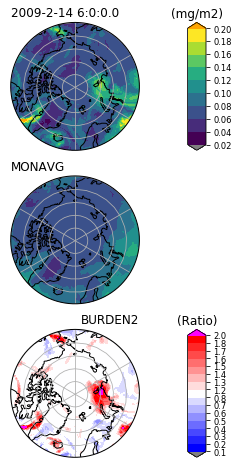

done with time 2009_02_14h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-09-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_09h06_R.pdf
data range 0.03989575 0.21799435
data range 0.049362756 0.1358432
dtrng [0.         2.42537284]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.46341613 2.4253728


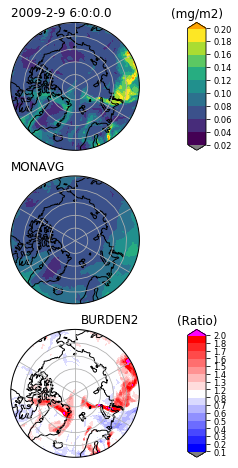

done with time 2009_02_09h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-04-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_04h06_R.pdf
data range 0.030409114 0.24906836
data range 0.049362756 0.1358432
dtrng [0.         2.43748355]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.34772536 2.4374835


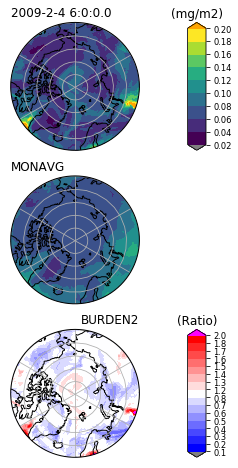

done with time 2009_02_04h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-07-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_07h06_R.pdf
data range 0.036107447 0.319877
data range 0.049362756 0.1358432
dtrng [0.         2.88154078]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
data range 0.4098985 2.8815408


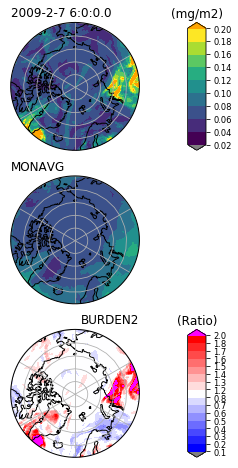

done with time 2009_02_07h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-26-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_26h06_R.pdf
data range 0.03627646 0.40877956
data range 0.049362756 0.1358432
dtrng [0.         4.65142155]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
data range 0.38794538 4.6514215


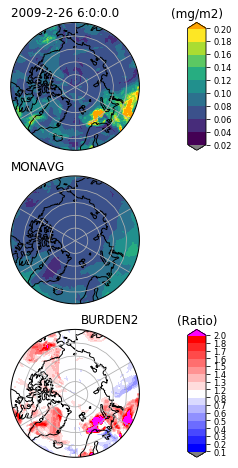

done with time 2009_02_26h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-22-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_22h06_R.pdf
data range 0.040040728 0.5500454
data range 0.049362756 0.1358432
dtrng [0.         5.70220423]
dlevs1 [-2.5 -2.  -1.5 -1.  -0.5  0.5  1.   1.5  2.   2.5]
data range 0.46600866 5.702204


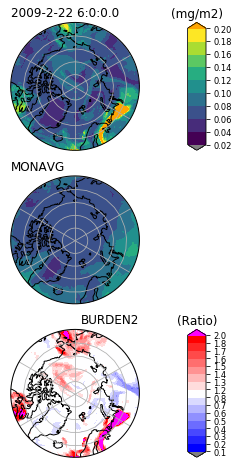

done with time 2009_02_22h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-21-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_21h06_R.pdf
data range 0.037569083 0.7084684
data range 0.049362756 0.1358432
dtrng [0.         5.50483465]
dlevs1 [-2.5 -2.  -1.5 -1.  -0.5  0.5  1.   1.5  2.   2.5]
data range 0.41630694 5.5048347


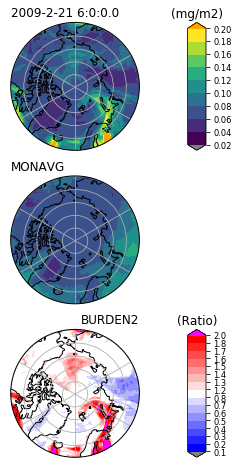

done with time 2009_02_21h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-17-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_17h06_R.pdf
data range 0.03953801 0.265112
data range 0.049362756 0.1358432
dtrng [0.         3.28680325]
dlevs1 [-1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2
  1.4  1.6]
data range 0.48294383 3.2868032


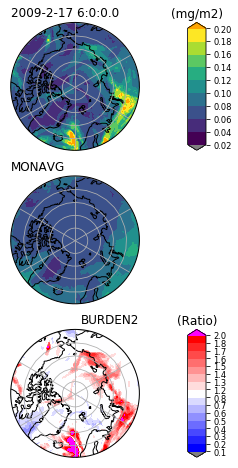

done with time 2009_02_17h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-10-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_10h06_R.pdf
data range 0.036618393 0.34731477
data range 0.049362756 0.1358432
dtrng [0.         3.34060836]
dlevs1 [-1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2
  1.4  1.6]
data range 0.44467336 3.3406084


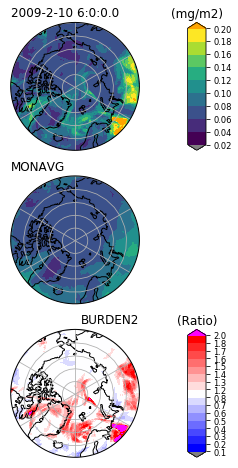

done with time 2009_02_10h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-27-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_27h06_R.pdf
data range 0.04405891 0.29629117
data range 0.049362756 0.1358432
dtrng [0.         3.27835798]
dlevs1 [-1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2
  1.4  1.6]
data range 0.53591096 3.278358


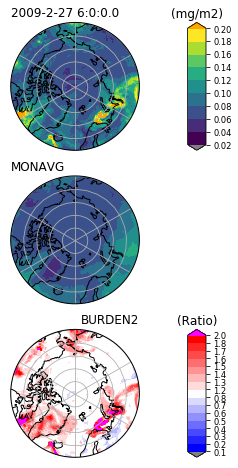

done with time 2009_02_27h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-11-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_11h06_R.pdf
data range 0.033679213 0.2609254
data range 0.049362756 0.1358432
dtrng [0.         2.39109969]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
data range 0.4419718 2.3910997


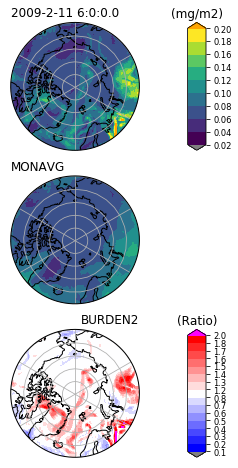

done with time 2009_02_11h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-15-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_15h06_R.pdf
data range 0.029105917 0.2945781
data range 0.049362756 0.1358432
dtrng [0.         2.63504076]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.46976528 2.6350408


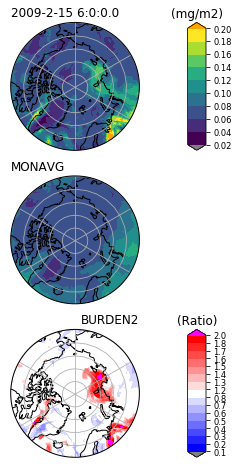

done with time 2009_02_15h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-19-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_19h06_R.pdf
data range 0.036782566 0.19843042
data range 0.049362756 0.1358432
dtrng [0.         2.13789392]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
data range 0.47851014 2.137894


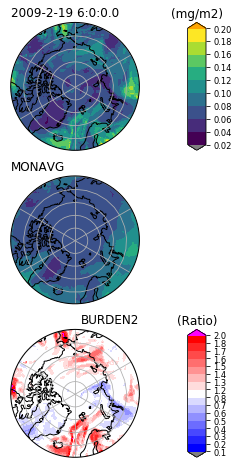

done with time 2009_02_19h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-24-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_24h06_R.pdf
data range 0.03743762 0.24673818
data range 0.049362756 0.1358432
dtrng [0.         2.84609199]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
data range 0.42142096 2.846092


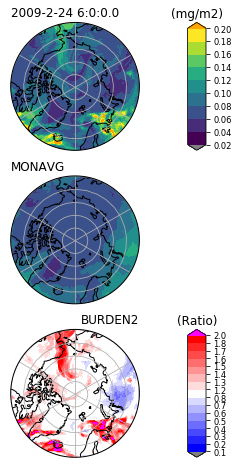

done with time 2009_02_24h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-01-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_01h06_R.pdf
data range 0.030252893 0.2902207
data range 0.049362756 0.1358432
dtrng [0.         3.60257196]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
data range 0.39937153 3.602572


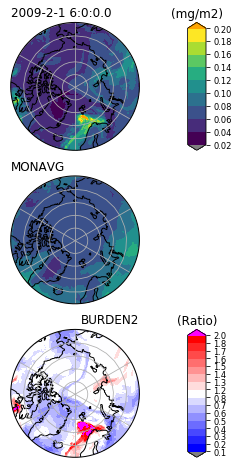

done with time 2009_02_01h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-20-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_20h06_R.pdf
data range 0.03363435 0.28478375
data range 0.049362756 0.1358432
dtrng [0.         3.07038689]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
data range 0.4064676 3.070387


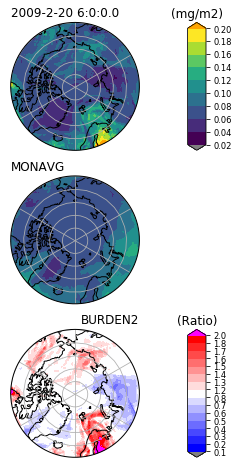

done with time 2009_02_20h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-06-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_06h06_R.pdf
data range 0.029472042 0.31464234
data range 0.049362756 0.1358432
dtrng [0.         3.15200543]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
data range 0.34368724 3.1520054


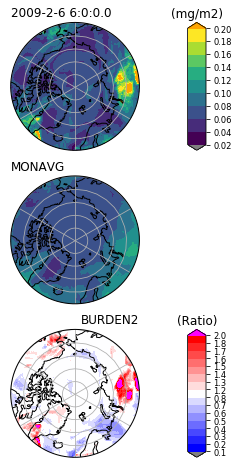

done with time 2009_02_06h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-28-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_28h06_R.pdf
data range 0.04816868 0.28238446
data range 0.049362756 0.1358432
dtrng [0.         2.53041649]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.53467584 2.5304165


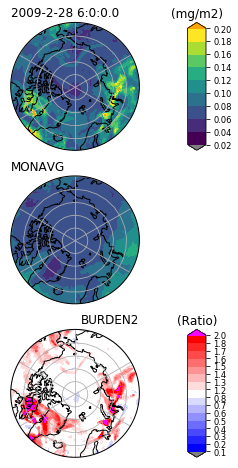

done with time 2009_02_28h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-13-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_13h06_R.pdf
data range 0.037767947 0.26277527
data range 0.049362756 0.1358432
dtrng [0.         2.50588584]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.47220704 2.5058858


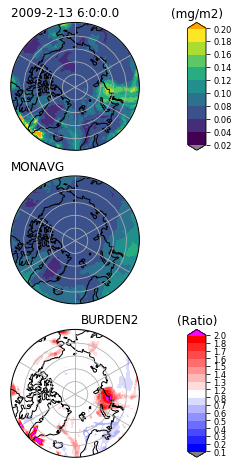

done with time 2009_02_13h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-12-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_12h06_R.pdf
data range 0.03888879 0.2931435
data range 0.049362756 0.1358432
dtrng [0.         2.47631717]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.45566946 2.4763172


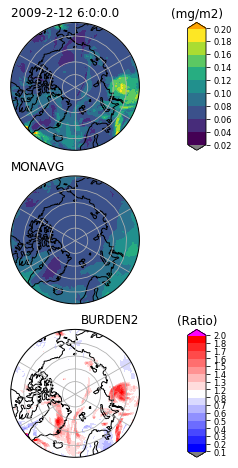

done with time 2009_02_12h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-08-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_08h06_R.pdf
data range 0.034170136 0.27050322
data range 0.049362756 0.1358432
dtrng [0.         2.96785998]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
data range 0.4173097 2.96786


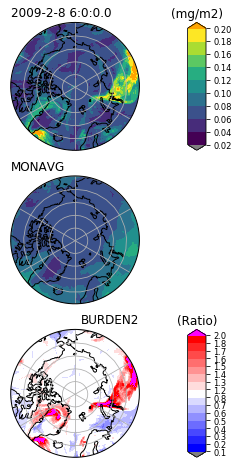

done with time 2009_02_08h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-25-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_25h06_R.pdf
data range 0.036223024 0.37722555
data range 0.049362756 0.1358432
dtrng [0.         4.18793106]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
data range 0.4306647 4.187931


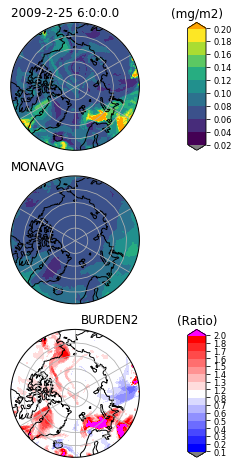

done with time 2009_02_25h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-03-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_03h06_R.pdf
data range 0.029452348 0.2084762
data range 0.049362756 0.1358432
dtrng [0.         1.94300759]
dlevs1 [-0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8]
data range 0.39640406 1.9430076


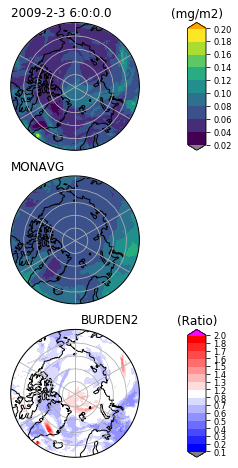

done with time 2009_02_03h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-05-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_05h06_R.pdf
data range 0.036903486 0.40655133
data range 0.049362756 0.1358432
dtrng [0.        3.4283371]
dlevs1 [-1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2
  1.4  1.6]
data range 0.4030569 3.428337


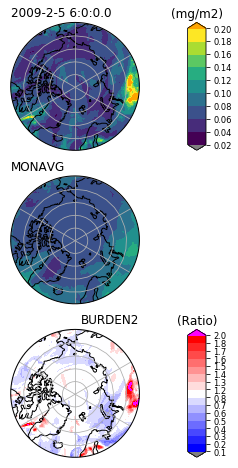

done with time 2009_02_05h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-18-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_18h06_R.pdf
data range 0.03891676 0.22465776
data range 0.049362756 0.1358432
dtrng [0.         2.71781874]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.4998349 2.7178187


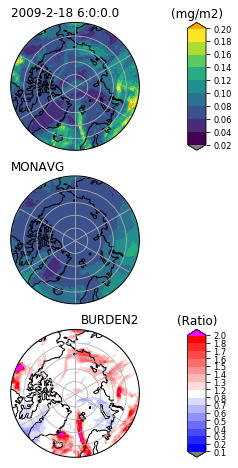

done with time 2009_02_18h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-23-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_23h06_R.pdf
data range 0.042212866 0.4147407
data range 0.049362756 0.1358432
dtrng [0.         3.34501982]
dlevs1 [-1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2
  1.4  1.6]
data range 0.46792212 3.3450198


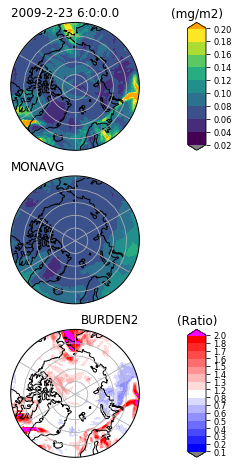

done with time 2009_02_23h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-16-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_16h06_R.pdf
data range 0.028113674 0.22572692
data range 0.049362756 0.1358432
dtrng [0.         2.35195708]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
data range 0.4904147 2.351957


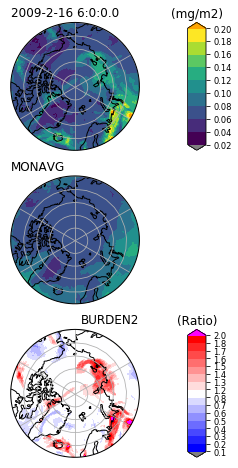

done with time 2009_02_16h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-02-21600.nc
figure being saved to  workdir/BURDEN2_2009_02_02h06_R.pdf
data range 0.032614265 0.18790743
data range 0.049362756 0.1358432
dtrng [0.         1.91030705]
dlevs1 [-0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8]
data range 0.41267487 1.910307


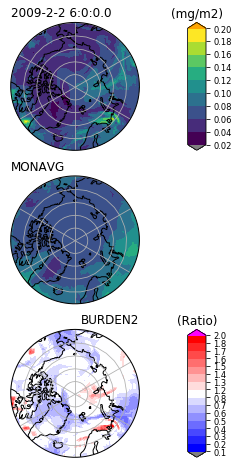

done with time 2009_02_02h06



processtime complete
processing time average
jname1  /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h0.2009-03.nc
reference dataset is jname1 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h0.2009-03.nc
processing timeslice from dir2  /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/
jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-17-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_17h06_R.pdf
data range 0.041082967 0.31370816
data range 0.052624557 0.14745806
dtrng [0.         2.78009391]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.4820403 2.780094


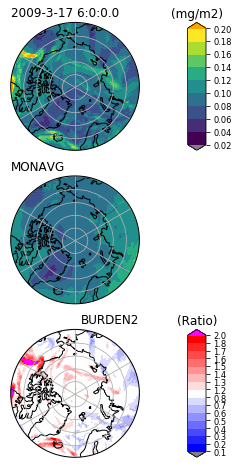

done with time 2009_03_17h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-15-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_15h06_R.pdf
data range 0.04153187 0.24038468
data range 0.052624557 0.14745806
dtrng [0.         2.26704669]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
data range 0.52867717 2.2670467


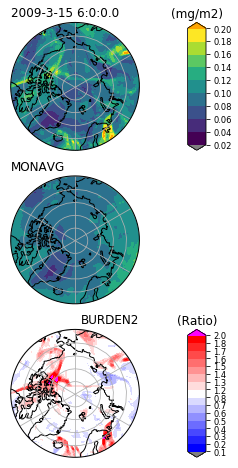

done with time 2009_03_15h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-16-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_16h06_R.pdf
data range 0.03993232 0.22263807
data range 0.052624557 0.14745806
dtrng [0.         2.10028172]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
data range 0.46286348 2.1002817


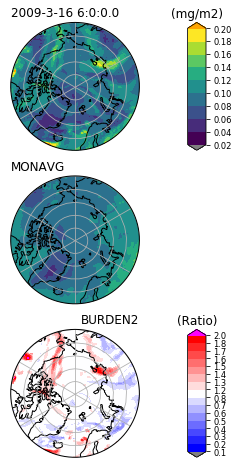

done with time 2009_03_16h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-21-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_21h06_R.pdf
data range 0.03251099 0.3114298
data range 0.052624557 0.14745806
dtrng [0.         2.75199318]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.3603671 2.7519932


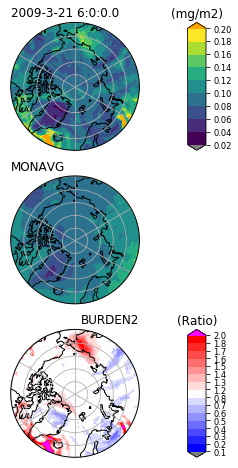

done with time 2009_03_21h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-31-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_31h06_R.pdf
data range 0.04242871 0.2376181
data range 0.052624557 0.14745806
dtrng [0.         2.24421382]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
data range 0.44461262 2.2442138


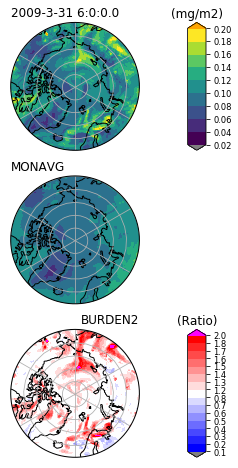

done with time 2009_03_31h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-02-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_02h06_R.pdf
data range 0.04047277 0.5990179
data range 0.052624557 0.14745806
dtrng [0.         5.06154156]
dlevs1 [-2.5 -2.  -1.5 -1.  -0.5  0.5  1.   1.5  2.   2.5]
data range 0.4016459 5.0615416


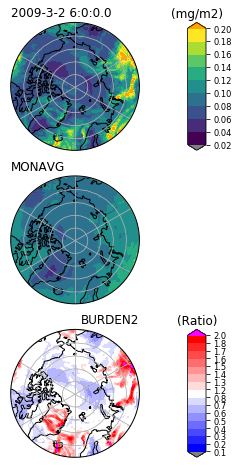

done with time 2009_03_02h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-04-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_04h06_R.pdf
data range 0.04301255 0.33789948
data range 0.052624557 0.14745806
dtrng [0.        2.9374938]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
data range 0.41902602 2.9374938


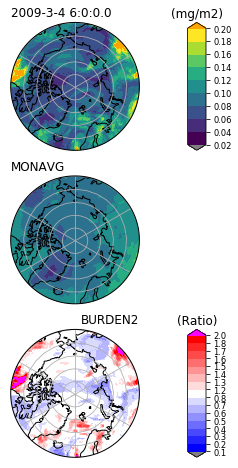

done with time 2009_03_04h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-11-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_11h06_R.pdf
data range 0.04224894 0.34020343
data range 0.052624557 0.14745806
dtrng [0.        2.8907249]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
data range 0.46909788 2.890725


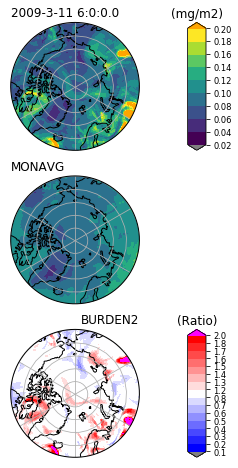

done with time 2009_03_11h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-22-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_22h06_R.pdf
data range 0.03720046 0.28171054
data range 0.052624557 0.14745806
dtrng [0.         2.57530284]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.4287963 2.5753028


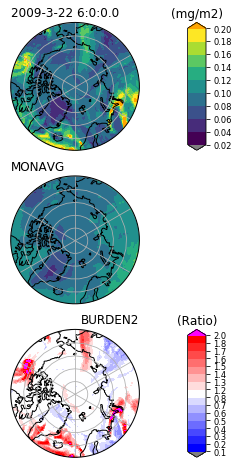

done with time 2009_03_22h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-26-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_26h06_R.pdf
data range 0.04485857 0.2710098
data range 0.052624557 0.14745806
dtrng [0.         2.54566145]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.47668523 2.5456614


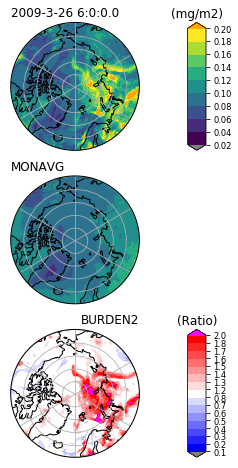

done with time 2009_03_26h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-07-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_07h06_R.pdf
data range 0.041057386 0.22114977
data range 0.052624557 0.14745806
dtrng [0.         2.59091234]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.38432294 2.5909123


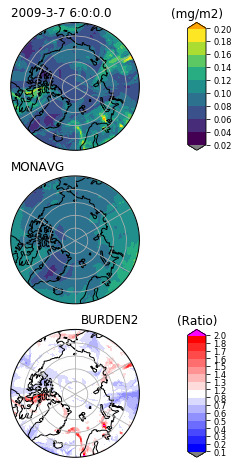

done with time 2009_03_07h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-23-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_23h06_R.pdf
data range 0.04072054 0.338046
data range 0.052624557 0.14745806
dtrng [0.         3.09485078]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
data range 0.44705 3.0948508


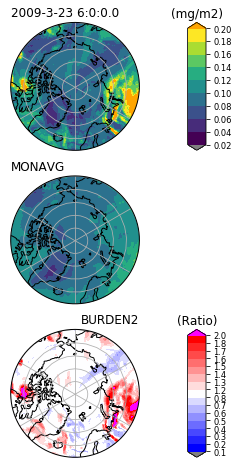

done with time 2009_03_23h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-19-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_19h06_R.pdf
data range 0.03974139 0.23278654
data range 0.052624557 0.14745806
dtrng [0.         2.11407757]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
data range 0.46331617 2.1140776


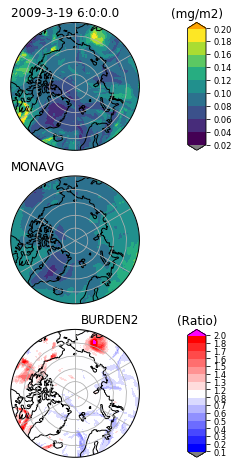

done with time 2009_03_19h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-28-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_28h06_R.pdf
data range 0.041173648 0.32481107
data range 0.052624557 0.14745806
dtrng [0.         2.84125113]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
data range 0.5812745 2.8412511


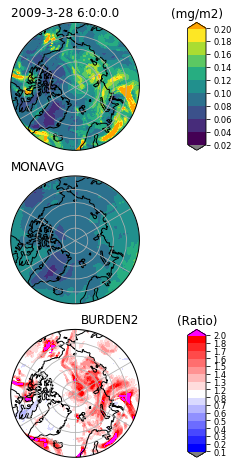

done with time 2009_03_28h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-01-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_01h06_R.pdf
data range 0.042878084 0.45047984
data range 0.052624557 0.14745806
dtrng [0.        3.8085115]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
data range 0.4108853 3.8085115


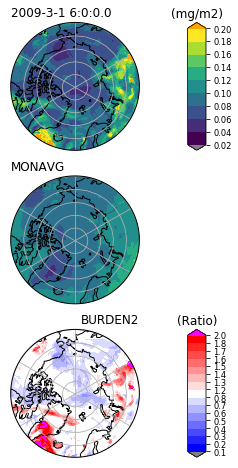

done with time 2009_03_01h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-12-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_12h06_R.pdf
data range 0.04386125 0.28031895
data range 0.052624557 0.14745806
dtrng [0.         2.59970021]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.5341661 2.5997002


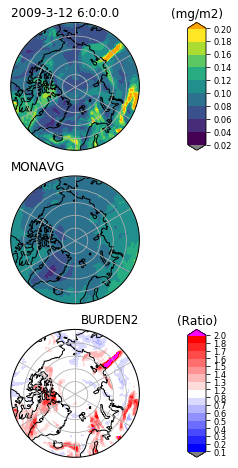

done with time 2009_03_12h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-18-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_18h06_R.pdf
data range 0.039096024 0.23653707
data range 0.052624557 0.14745806
dtrng [0.         2.13180375]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
data range 0.4861194 2.1318038


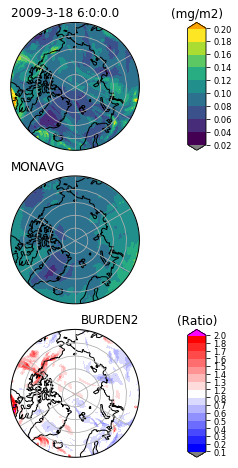

done with time 2009_03_18h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-20-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_20h06_R.pdf
data range 0.034679834 0.24210002
data range 0.052624557 0.14745806
dtrng [0.         2.17662144]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
data range 0.4333012 2.1766214


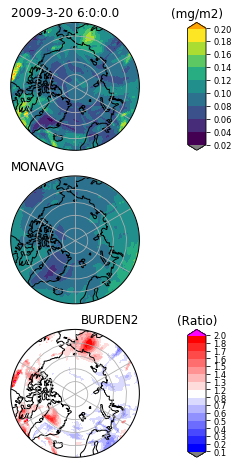

done with time 2009_03_20h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-24-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_24h06_R.pdf
data range 0.039222687 0.34481844
data range 0.052624557 0.14745806
dtrng [0.         3.11542296]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
data range 0.41239265 3.115423


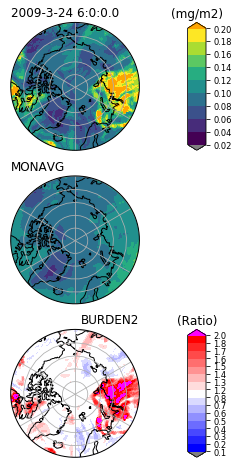

done with time 2009_03_24h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-27-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_27h06_R.pdf
data range 0.050083935 0.2647387
data range 0.052624557 0.14745806
dtrng [0.         2.48092341]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.51782125 2.4809234


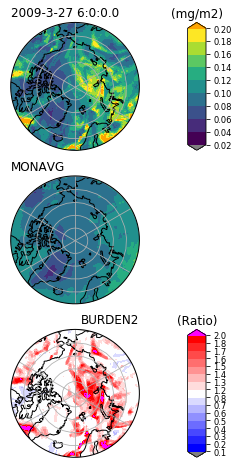

done with time 2009_03_27h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-09-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_09h06_R.pdf
data range 0.043287423 0.28823525
data range 0.052624557 0.14745806
dtrng [0.         2.43802643]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.47589236 2.4380264


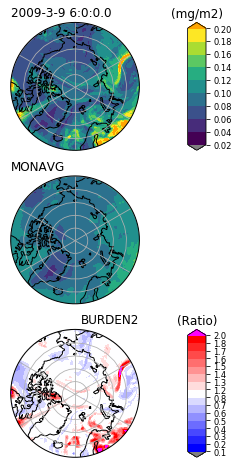

done with time 2009_03_09h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-10-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_10h06_R.pdf
data range 0.04108606 0.31606472
data range 0.052624557 0.14745806
dtrng [0.         2.83583283]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
data range 0.46401253 2.8358328


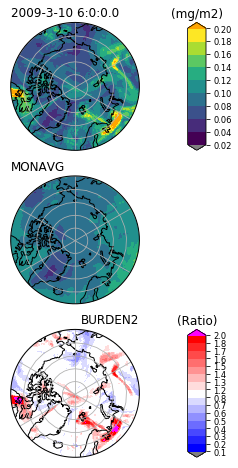

done with time 2009_03_10h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-25-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_25h06_R.pdf
data range 0.046400744 0.29987267
data range 0.052624557 0.14745806
dtrng [0.         2.76928496]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.49937624 2.769285


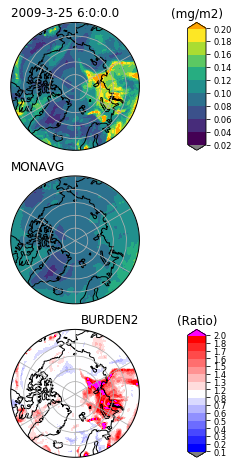

done with time 2009_03_25h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-06-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_06h06_R.pdf
data range 0.040647097 0.2599312
data range 0.052624557 0.14745806
dtrng [0.         2.50462031]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.4814847 2.5046203


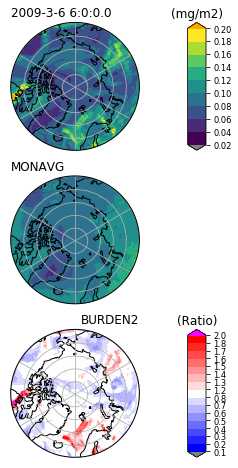

done with time 2009_03_06h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-13-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_13h06_R.pdf
data range 0.041991293 0.24961087
data range 0.052624557 0.14745806
dtrng [0.         2.50010777]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.5018934 2.5001078


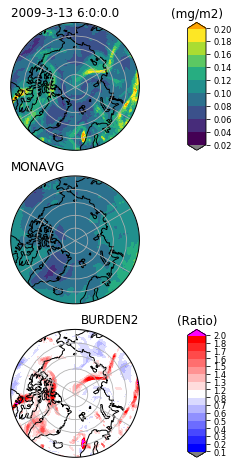

done with time 2009_03_13h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-14-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_14h06_R.pdf
data range 0.04429168 0.22071995
data range 0.052624557 0.14745806
dtrng [0.         2.38520026]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
data range 0.5048779 2.3852003


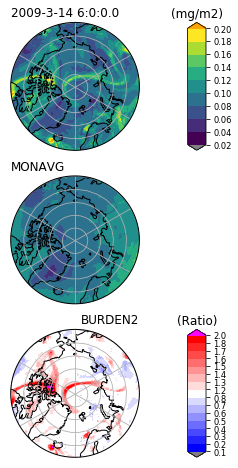

done with time 2009_03_14h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-30-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_30h06_R.pdf
data range 0.043139033 0.29872593
data range 0.052624557 0.14745806
dtrng [0.         3.00663638]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
data range 0.5220316 3.0066364


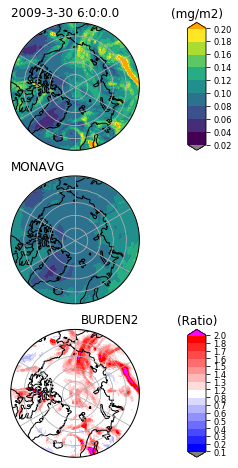

done with time 2009_03_30h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-29-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_29h06_R.pdf
data range 0.03980134 0.29616308
data range 0.052624557 0.14745806
dtrng [0.         2.69090486]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.4210778 2.6909049


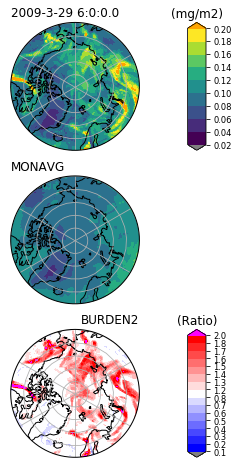

done with time 2009_03_29h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-03-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_03h06_R.pdf
data range 0.043988436 0.4837073
data range 0.052624557 0.14745806
dtrng [0.         4.27826595]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
data range 0.42121166 4.278266


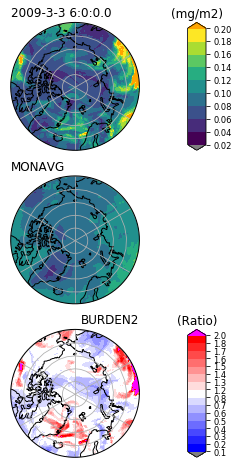

done with time 2009_03_03h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-08-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_08h06_R.pdf
data range 0.039749447 0.308277
data range 0.052624557 0.14745806
dtrng [0.         2.41269898]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
data range 0.38540202 2.412699


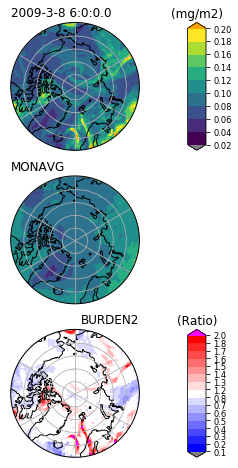

done with time 2009_03_08h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-05-21600.nc
figure being saved to  workdir/BURDEN2_2009_03_05h06_R.pdf
data range 0.037239768 0.2768599


In [ ]:
mon = "01"
monlist = np.array(["02","03","04"])
for mon in monlist:
    dir1, f1, dir2, files = setupfilenames(mon)



    vname = "TMQ"
    plottype = "RATIO"
    
    vname = "BURDEN2"
    plottype = "DIFF"
    dfact = 0.5  # multiplier on contour levels for difference anomalies
    dfact = 1.0  
    
    plottype = "RATIO"

    #files = {files[0]} # select only the first file for debugging   
    processtime (vname, dir1, f1, dir2, files)
print "all done"